<a href="https://colab.research.google.com/github/habibarezq/ML-Assignments-25/blob/main/Assignment-2/notebooks/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [30]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader ## to feed the data into the model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

# 1. Data Preparation

### Required Preprocessing and Transformations

In [31]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224)
])

Load Training and test data

In [32]:
dataset=datasets.MNIST(root="./data", download=True, train=True, transform=transform)
test_data=datasets.MNIST(root="./data", download=True, train=False, transform=transform)


Extract data and labels

In [33]:
X= dataset.data.float() /255.0
y=dataset.targets

print(f"Full training data shape: {X.shape}")
print(f"Full training labels shape: {y.shape}")
print(f"Pixel value range: [{X.min():.2f}, {X.max():.2f}]")

Full training data shape: torch.Size([60000, 28, 28])
Full training labels shape: torch.Size([60000])
Pixel value range: [0.00, 1.00]


### Data Filtering

In [34]:
# Filter first: only digits 0 and 1 from the whole dataset
mask_train = (y == 0) | (y == 1)
X_binary = X[mask_train]
y_binary = y[mask_train]

### Data Splitting



In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_binary, y_binary, test_size=0.4, stratify=y_binary, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### Flatten Images

In [36]:
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

### Create Dataloaders

In [37]:
train_loader = DataLoader(
    TensorDataset(X_train_flat, y_train.float()),
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_flat, y_val.float()),
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_flat, y_test.float()),
    batch_size=32,
    shuffle=False
)

# 2. Logisitic Regression Implementation

In [76]:
def sigmoid(x):
  return 1 / (1+torch.exp(-x))

def binary_cross_entropy(y_pred,y_true):
  eps=1e-8 # avoid log(0)
  return -torch.mean(y_true *  torch.log(y_pred + eps) + (1-y_true)*torch.log(1-y_pred))
def forward_pass(X_batch,W,b):
   # Forward Pass
      scores= X_batch @ W +b
      y_pred=sigmoid(scores)
      return y_pred

def compute_accuracy(y_pred,y_true):
  threshold= (y_pred >=0.5)
  predictions =threshold.float()
  # predictions has shape (batch_size,1) while y_true has shape (batch_size,) thus using squeeze for predictions
  accuracy =(predictions.squeeze() == y_true).float().mean()
  return accuracy.item()

def compute_gradients(X_batch,y_batch,y_pred):
  error = y_pred - y_batch.unsqueeze(1)
  dW=(X_batch.T @ error ) / X_batch.shape[0]
  db=error.mean() # summation of error for batch divided by their number
  return dW,db

def update_weights(W,b,dW,db,alpha):
  W -= alpha * dW
  b -= alpha * db
  return W,b

def print_metrics(epoch,epochs,train_losses,train_accuracies,val_losses,val_accuracies):
  if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


### Training Loop

#### Initalize weights and bias


In [125]:
n_features=28*28
W=torch.zeros(n_features,1,requires_grad=False)
b=torch.zeros(1,requires_grad=False) #Compute the grad manually

## Hyperparameters
patience=10 # how many epochs to wait for improvmenet
learning_rate=0.01
min_delta=0.0005 # min change to qualify as improvement
max_epochs=200


### Training Loop

In [124]:
def train_model(train_loader,val_loader,W,b,learning_rate,max_epochs,patience,min_delta,early_stopping=False):
  # Training History
  train_losses=[]
  val_losses=[]
  train_accuracies=[]
  val_accuracies=[]

  # Tracking variables
  best_val_loss= float('inf')
  epochs_without_improvement=0
  best_W=None
  best_b=None

  for epoch in range(max_epochs):
    # Training Phase
    train_loss_epoch=0
    train_acc_epoch=0
    n_train_batches=0 # Number of training batches

    for X_batch,y_batch in train_loader:
      # Forward Pass
      y_pred= forward_pass(X_batch,W,b)

      # Compute loss y_pred --> (batch_size,1) while y_batch has (batch,) --> use unsqueeze to a dimension
      loss=binary_cross_entropy(y_pred,y_batch.unsqueeze(1))

      #Compute Gradients
      dW,db=compute_gradients(X_batch,y_batch,y_pred)

      # Update Weights
      W,b=update_weights(W,b,dW,db,learning_rate)

      # Metrics
      train_loss_epoch += loss.item()
      train_acc_epoch += compute_accuracy(y_pred,y_batch)
      n_train_batches += 1


    # Validation Phase
    val_loss_epoch =0
    val_acc_epoch=0
    n_val_batches=0 # Number of training batches

    with torch.no_grad(): ## disables gradient computation bec we are evaluating not training
      for X_batch,y_batch in val_loader:
        # Foward pass
        y_pred = forward_pass(X_batch,W,b)

        # Compute Loss
        loss = binary_cross_entropy(y_pred,y_batch.unsqueeze(1))

        # Metrics
        val_loss_epoch += loss.item()
        val_acc_epoch += compute_accuracy(y_pred,y_batch)
        n_val_batches +=1

    # Record each epoch metrics
    avg_train_loss = train_loss_epoch / n_train_batches
    avg_val_loss = val_loss_epoch / n_val_batches

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc_epoch/n_train_batches)
    val_accuracies.append(val_acc_epoch/n_val_batches)
    val_losses.append(avg_val_loss)

    # Print progress
    print_metrics(epoch,max_epochs,train_losses,train_accuracies,val_losses,val_accuracies)

    # Early Stopping logic
    if early_stopping:
      if avg_val_loss < best_val_loss - min_delta:
        # There's improvement
        best_val_loss=avg_val_loss
        epochs_without_improvement =0

        # Save best models output
        best_W =W.clone()
        best_b =b.clone()
        # print(f"Epoch {epoch+1:3d}: Val Loss improved to {avg_val_loss:.4f}")

      else:
        # No improvement
        epochs_without_improvement +=1
        # print(f"Epoch {epoch+1:3d}: No improvement ({epochs_without_improvement}/{patience})")

      if epochs_without_improvement >= patience:
        print("\n" + "="*60)
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {epoch+1-patience}")
        print("="*60)
        break

    # Restore best model
  if early_stopping and best_W is not None:
    W = best_W
    b = best_b
    print(f"\nRestored best model (Val Loss = {best_val_loss:.4f})")

  return W, b, train_losses, val_losses, train_accuracies, val_accuracies

In [126]:
W, b, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    train_loader, val_loader, W, b,
    learning_rate=learning_rate,
    max_epochs=100,
    early_stopping=False,
    patience=patience,
    min_delta=min_delta
)

Epoch 10/100 - Train Loss: 0.0132, Train Acc: 0.9980 - Val Loss: 0.0143, Val Acc: 0.9973
Epoch 20/100 - Train Loss: 0.0090, Train Acc: 0.9980 - Val Loss: 0.0101, Val Acc: 0.9973
Epoch 30/100 - Train Loss: 0.0074, Train Acc: 0.9983 - Val Loss: 0.0085, Val Acc: 0.9980
Epoch 40/100 - Train Loss: 0.0065, Train Acc: 0.9986 - Val Loss: 0.0075, Val Acc: 0.9980
Epoch 50/100 - Train Loss: 0.0059, Train Acc: 0.9988 - Val Loss: 0.0069, Val Acc: 0.9980
Epoch 60/100 - Train Loss: 0.0054, Train Acc: 0.9988 - Val Loss: 0.0065, Val Acc: 0.9980
Epoch 70/100 - Train Loss: 0.0051, Train Acc: 0.9988 - Val Loss: 0.0061, Val Acc: 0.9980
Epoch 80/100 - Train Loss: 0.0048, Train Acc: 0.9988 - Val Loss: 0.0059, Val Acc: 0.9980
Epoch 90/100 - Train Loss: 0.0046, Train Acc: 0.9988 - Val Loss: 0.0057, Val Acc: 0.9980
Epoch 100/100 - Train Loss: 0.0044, Train Acc: 0.9988 - Val Loss: 0.0055, Val Acc: 0.9980


### Visualization

1. Loss Curves

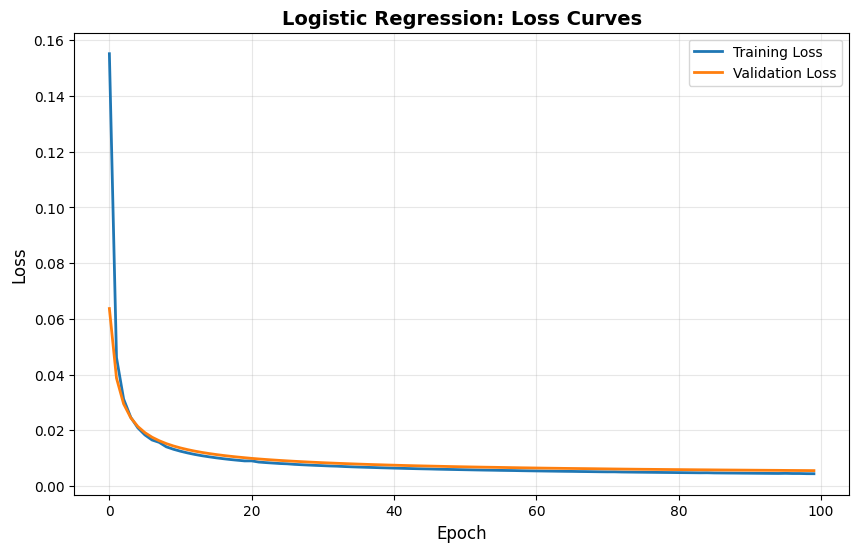

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Logistic Regression: Loss Curves', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

2. Accuracies Curve

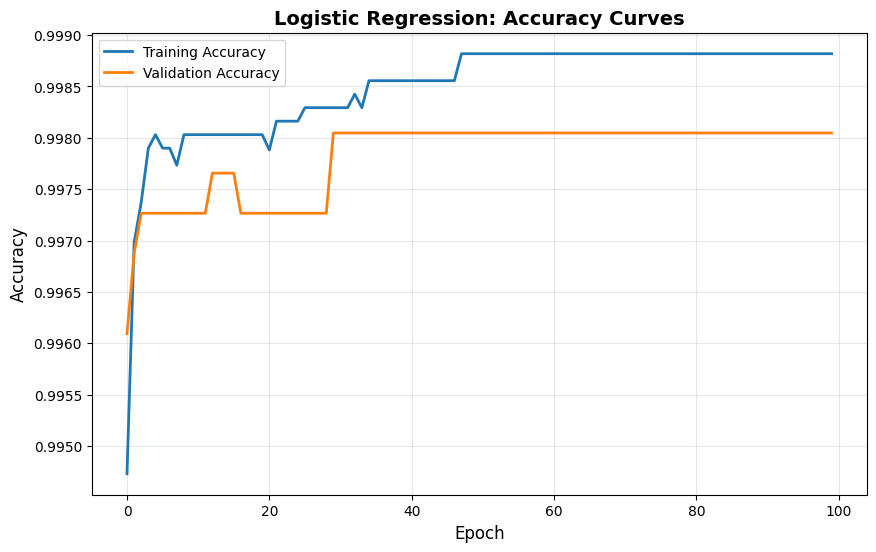

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Logistic Regression: Accuracy Curves', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()